In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from scipy import ndimage
from skimage.feature import peak_local_max
from sklearn.cluster import DBSCAN, AffinityPropagation, MeanShift
from matplotlib import cm

In [2]:
MIN = 0
MAX = 2 ** 16 - 1

In [21]:
def import_sequences():
    PATH = '../sequences/0'
    imgs = []
    for i in range(1, 5):
        imgs_path = []
        for image in glob(f'{PATH}{i}/*.tif'):
            img = cv2.imread(image, -1)
            imgs_path.append(cv2.normalize(img, dst=None, alpha=MIN, beta=MAX, norm_type=cv2.NORM_MINMAX))
        imgs.append(imgs_path)
    return imgs

In [22]:
imgs = import_sequences()

In [4]:
NROWS = imgs[0][0].shape[0]
NCOLS = imgs[0][0].shape[1]

In [5]:
def show(img, s=True):
    plt.imshow(img, cmap='gray')
    if s:
        plt.show()

In [25]:
def segment(original):
    img = np.zeros_like(original)
    cv2.threshold(original, dst=img, thresh=np.median(original)*1.2, maxval=MAX, type=cv2.THRESH_BINARY)
    struct_element = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(5,5))
    img1 = np.zeros_like(original)
    cv2.morphologyEx(img, dst=img1, op=cv2.MORPH_OPEN, kernel=struct_element, borderValue=cv2.BORDER_REFLECT)
    img2 = np.zeros_like(original)
    cv2.threshold(img1, dst=img2, thresh=MAX-1, maxval=MAX, type=cv2.THRESH_BINARY)
    return img2

In [7]:
def points(img):
    pts = {}
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j] == MAX:
                pts[(i,j)] = None
    return pts

In [8]:
def create_img(pts):
    new = np.zeros((NROWS, NCOLS))
    for (i, j) in pts:
        new[i, j] = MAX
    return new

In [9]:
def flush_border_cells(pts, img):
    to_check = []
    border_pts = {}
    border_img = np.zeros((NROWS, NCOLS))
    for pt in pts:
        if pt[0] == 0 or pt[1] == 0 or pt[0] == NROWS-1 or pt[1] == NCOLS-1:
            to_check.append(pt)
            border_pts[pt] = None
            border_img[pt[0], pt[1]] = MAX
    cnt = 0
    while cnt < 50000:
        if len(to_check) == 0:
            break
        if cnt == 49999:
            print(len(to_check))
        b_pt = to_check.pop(0)
        for i in range(-1, 2):
            for j in range(-1, 2):
                if (b_pt[0]+i, b_pt[1]+j) in pts and (b_pt[0]+i, b_pt[1]+j) not in border_pts:
                    to_check.append((b_pt[0]+i, b_pt[1]+j))
                    border_pts[(b_pt[0]+i, b_pt[1]+j)] = None
                    border_img[b_pt[0]+i, b_pt[1]+j] = MAX
        cnt += 1
    new = img - border_img
    return new.astype('uint16'), border_pts

In [10]:
def colour_label_image(pts_labels, show=True):
    cmap = cm.get_cmap('hsv').copy()
    new_img = np.zeros((NROWS, NCOLS))
    cmap.set_bad(color='black')
    for (pt, label) in pts_labels.items():
        new_img[pt[0],pt[1]] = label
    norm_new = plt.Normalize(new_img.min(), new_img.max())
    for i in range(NROWS):
        for j in range(NCOLS):
            if (i,j) not in pts_labels:
                new_img[i,j] = np.nan
    rgba_img = cmap(norm_new(new_img))
    if show:
        plt.imshow(rgba_img)
        plt.show()
    return rgba_img

In [11]:
def plt_rgb_img_scatter(cs, pts_labels=None):
    rgb_img = colour_label_image(pts_labels, False)
    plt.imshow(rgb_img)
    if pts_labels != None:
        for (x, y) in cs.values():
            plt.scatter(y, x, c='white', marker='o')
    plt.show()

In [12]:
def check_coords(pt):
    if pt[0] < 0 or pt[0] > NROWS-1 or pt[1] < 0 or pt[1] > NCOLS-1:
        return False
    return True

In [13]:
def erode(pts):
    eroded1_pts = {}
    for (x,y) in pts:
        if (x,y-1) in pts and (x, y+1) in pts:
            eroded1_pts[(x,y)] = pts[(x,y)]
    eroded2_pts = {}
    for (x,y) in eroded1_pts:
        if (x-1,y) in eroded1_pts and (x+1, y) in eroded1_pts:
            eroded2_pts[(x,y)] = eroded1_pts[(x,y)]
    return eroded2_pts

In [14]:
def dilate(pts):
    dilated1_pts = pts.copy()
    for (x,y) in pts:
        if (x,y-1) not in pts and check_coords((x,y-1)):
            dilated1_pts[(x, y-1)] = pts[(x,y)]
        if (x, y+1) not in pts and check_coords((x,y+1)):
            dilated1_pts[(x, y+1)] = pts[(x,y)]
    dilated2_pts = dilated1_pts.copy()
    for (x,y) in dilated1_pts:
        if (x-1,y) not in dilated1_pts and check_coords((x-1,y)):
            dilated2_pts[(x-1, y)] = dilated1_pts[(x,y)]
        if (x+1, y) not in dilated1_pts and check_coords((x+1,y)):  
            dilated2_pts[(x+1, y)] = dilated1_pts[(x,y)]
    return dilated2_pts

In [20]:
def contours(pts):
    dilated2_pts = dilate(pts)
    sub = {}
    for pt, label in dilated2_pts.items():
        if pt not in pts:
            sub[pt] = label
    return sub

In [16]:
def no_collision(pt, label, existing_pts):
    for (i,j) in [(0, -1), (0, 1), (-1, 0), (1, 0)]:
        point = (pt[0]+i,pt[1]+j)
        if point in existing_pts and label != existing_pts[point]:
                return False
    '''
    for i in range(-1, 2):
        for j in range(-1, 2):
            point = (pt[0]+i,pt[1]+j)
            if point in existing_pts and label != existing_pts[point]:
                return False
    '''
    return True

In [31]:
def rebuild(img, show=True):
    # could use flushed image? Depends on cell tracking
    pts = points(img)
    distance = ndimage.distance_transform_edt(img)
    coords = peak_local_max(distance, footprint=np.ones((7,7)), labels = img, min_distance=12)
    coords = {tuple(c): i for i, c in enumerate(coords)}
    
    dilated2_pts = coords.copy()
    while 1:
        base = dilated2_pts.copy()
        dilated1_pts = base.copy()
        for pt, label in base.items():
            pt1 = (pt[0],pt[1]-1)
            if pt1 in dilated1_pts:
                pass
            elif no_collision(pt1, label, dilated1_pts) and pt1 in pts:
                dilated1_pts[pt1] = label
            
            pt2 = (pt[0], pt[1]+1)
            if pt2 in dilated1_pts:
                pass
            elif no_collision(pt2, label, dilated1_pts) and pt2 in pts:
                dilated1_pts[pt2] = label
       
        dilated2_pts = dilated1_pts.copy()
        for pt, label in dilated1_pts.items():
            pt1 = (pt[0]-1,pt[1])
            if pt1 in dilated2_pts:
                pass
            elif no_collision(pt1, label, dilated2_pts) and pt1 in pts:
                dilated2_pts[pt1] = label
            
            pt2 = (pt[0]+1, pt[1])
            if pt2 in dilated2_pts:
                pass
            elif no_collision(pt2, label, dilated2_pts) and pt2 in pts:
                dilated2_pts[pt2] = label
        if base == dilated2_pts:
            break
    if show:
        colour_label_image(dilated2_pts)
    return dilated2_pts 

In [40]:
def centroids(pts):
    extrema = {}
    for (x,y), label in pts.items():
        if label not in extrema:
            extrema[label] = {'x1': x, 'x2': x, 'y1': y, 'y2': y}
        if x < extrema[label]['x1']:
            extrema[label]['x1'] = x
        elif x > extrema[label]['x2']:
            extrema[label]['x2'] = x
        if y < extrema[label]['y1']:
            extrema[label]['y1'] = y
        elif y > extrema[label]['y2']:
            extrema[label]['y2'] = y
    centres = {}
    for label, data in extrema.items():
        centres[label] = (int(abs(data['x2']-data['x2'])/2), 
                          int(abs(data['y1']-data['y2'])/2))
    return centres

In [41]:
seg = segment(imgs[0][0])

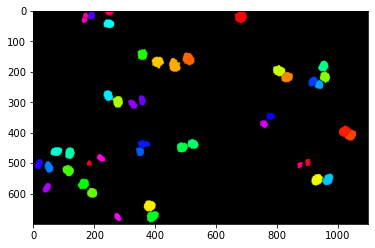

In [42]:
pts = rebuild(seg)

In [43]:
centroid = centroids(pts)

In [44]:
print(centroid)

{0: (0, 19), 1: (0, 19), 2: (0, 18), 3: (0, 19), 4: (0, 18), 5: (0, 18), 6: (0, 19), 7: (0, 19), 8: (0, 18), 9: (0, 20), 10: (0, 16), 11: (0, 16), 12: (0, 16), 13: (0, 18), 14: (0, 15), 15: (0, 18), 16: (0, 19), 17: (0, 17), 18: (0, 17), 19: (0, 16), 20: (0, 15), 21: (0, 18), 22: (0, 17), 23: (0, 15), 24: (0, 17), 25: (0, 14), 26: (0, 14), 27: (0, 12), 28: (0, 14), 29: (0, 20), 30: (0, 13), 31: (0, 13), 32: (0, 10), 33: (0, 10), 34: (0, 14), 35: (0, 13), 36: (0, 12), 37: (0, 11), 38: (0, 13), 39: (0, 9), 40: (0, 8), 41: (0, 8), 42: (0, 14), 43: (0, 8), 44: (0, 7)}
